<a href="https://colab.research.google.com/github/umiSirya/Weather_Prediction_capstone_project/blob/main/ARIMA_%26_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **UV Index Prediction for Italy with ARIMA and SARIMA Models**  

The data used for this analysis was sourced from the **World Ozone and Ultraviolet Radiation Data Centre (WOUDC)**: [https://woudc.org/data/explore.php?lang=en](https://woudc.org/data/explore.php?lang=en). The dataset specifically focuses on **UV index measurements in Italy**. The goal is to predict the **daily maximum UV index** using **ARIMA** and **SARIMA** models to capture both short-term dependencies and potential seasonality.  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import math
import sklearn

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [ ]:
df=pd.read_csv('/content/cleaned_uv_data.csv')
df.head()

,instance_date,uv_index_daily_max
0,1999-12-31,0.304709
1,2000-01-01,0.316398
2,2000-01-02,0.329537
3,2000-01-03,0.388613
4,2000-01-04,0.384048


# **Exploratory Data Analysis**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4116 entries, 0 to 4115
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   instance_date       4116 non-null   object 
 1   uv_index_daily_max  4116 non-null   float64
dtypes: float64(1), object(1)
memory usage: 64.4+ KB


In [ ]:
# Ensure the date column is datetime format and set it as the index
df['instance_date'] = pd.to_datetime(df['instance_date'])



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4116 entries, 0 to 4115
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   instance_date       4116 non-null   datetime64[ns]
 1   uv_index_daily_max  4116 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 64.4 KB


In [ ]:
# Set datetime as index
df.set_index('instance_date', inplace=True)

# **Data Pre-Processing**

# 1. Visualuzing The Data

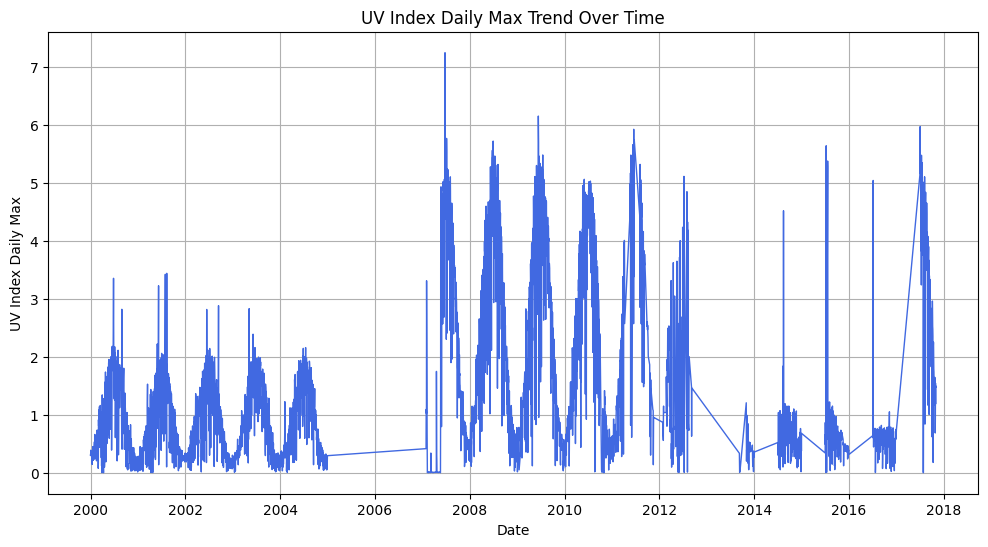

In [ ]:
# Plotting the original UV Index trend over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['uv_index_daily_max'], color='royalblue', linewidth=1)
plt.title('UV Index Daily Max Trend Over Time')
plt.xlabel('Date')
plt.ylabel('UV Index Daily Max')
plt.grid(True)
plt.show()

# 2. Checking for Stationarity

# 3. ADF Test and Decomposition for Stationarity Analysis

Original Data Stationarity Check:
ADF Statistic: -3.92
p-value: 0.002
✅ Data is stationary!


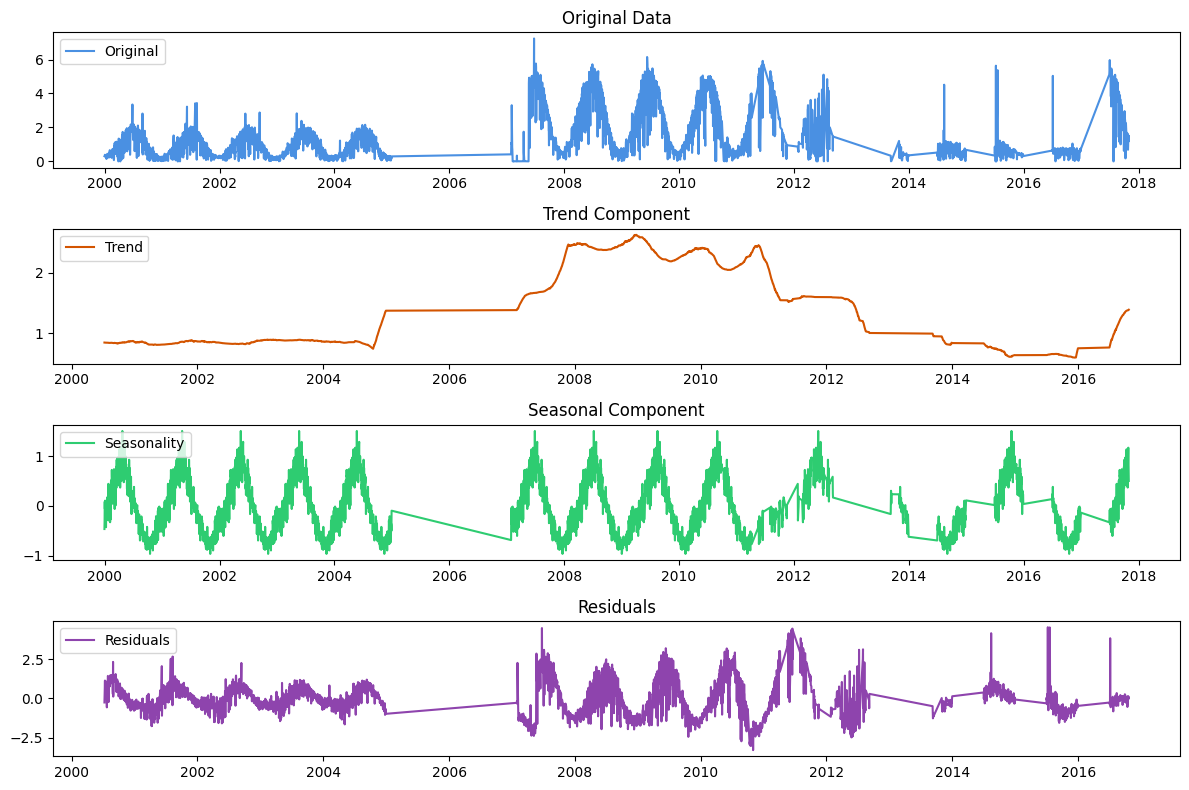

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# ADF Test function
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.2f}')
    print(f'p-value: {result[1]:.3f}')
    if result[1] <= 0.05:
        print("✅ Data is stationary!")
    else:
        print("❌ Data is still non-stationary.")

# Check stationarity on the original data
print("Original Data Stationarity Check:")
adf_test(df['uv_index_daily_max'])

# Seasonal decomposition on original data
try:
    decomposition = seasonal_decompose(df['uv_index_daily_max'], model='additive', period=365)

    # Plot decomposition results
    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(df['uv_index_daily_max'], label='Original', color='#4A90E2')
    plt.legend(loc='upper left')
    plt.title('Original Data')

    plt.subplot(4, 1, 2)
    plt.plot(decomposition.trend, label='Trend', color='#D35400')
    plt.legend(loc='upper left')
    plt.title('Trend Component')

    plt.subplot(4, 1, 3)
    plt.plot(decomposition.seasonal, label='Seasonality', color='#2ECC71')
    plt.legend(loc='upper left')
    plt.title('Seasonal Component')

    plt.subplot(4, 1, 4)
    plt.plot(decomposition.resid, label='Residuals', color='#8E44AD')
    plt.legend(loc='upper left')
    plt.title('Residuals')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"⚠️ Decomposition failed: {e}")


# Plot ACF & PACF

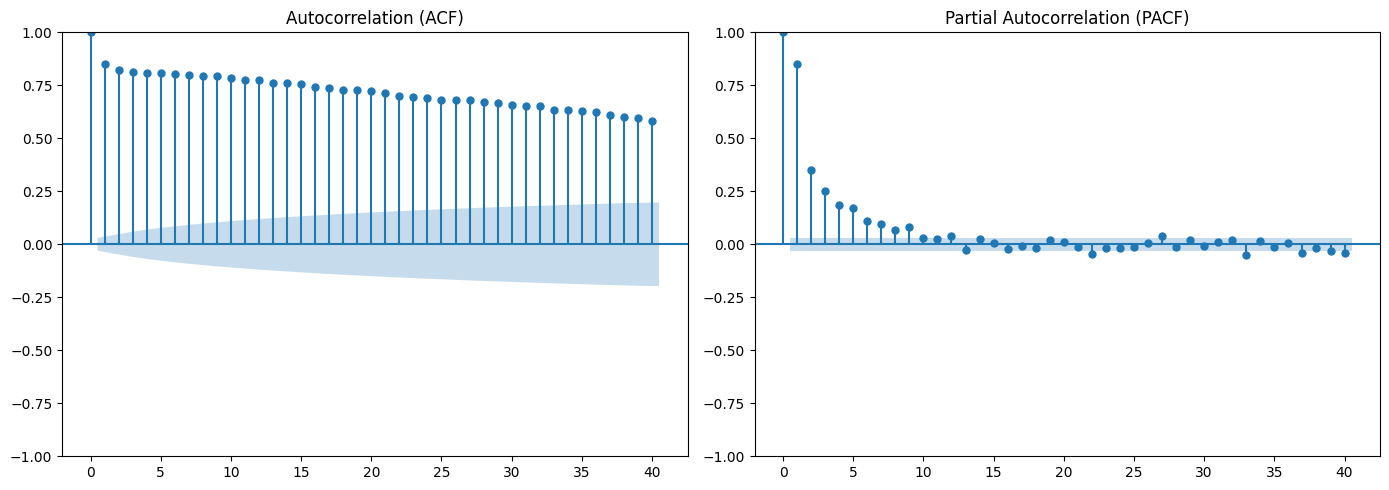

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(df['uv_index_daily_max'].dropna(), ax=ax[0], lags=40)
plot_pacf(df['uv_index_daily_max'].dropna(), ax=ax[1], lags=40)
ax[0].set_title('Autocorrelation (ACF)')
ax[1].set_title('Partial Autocorrelation (PACF)')
plt.tight_layout()
plt.show()

# Train and Test Split

In [ ]:
# Split data into train and test
cutoff_date = df.index.max() - pd.DateOffset(months=2)

# Use cutoff_date instead of split_date
train = df[df.index <= cutoff_date]
test= df[df.index > cutoff_date]

# Print the split sizes
print(f"Training data: {train.shape[0]} rows")
print(f"Test data: {test.shape[0]} rows")


Training data: 4055 rows
Test data: 61 rows


# ARIMA Model Training

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.2f}")
    print(f"p-value: {result[1]:.2f}")
    print("Stationary" if result[1] < 0.05 else "Not Stationary")

# Test original data
adf_test(df['uv_index_daily_max'])



ADF Statistic: -3.92
p-value: 0.00
Stationary


In [ ]:
arima_model = ARIMA(train['uv_index_daily_max'], order=(1, 1, 1))
arima_result = arima_model.fit()
print(arima_result.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:     uv_index_daily_max   No. Observations:                 4055
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3840.946
Date:                Fri, 21 Mar 2025   AIC                           7687.892
Time:                        19:45:35   BIC                           7706.814
Sample:                             0   HQIC                          7694.595
                               - 4055                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1507      0.011     14.035      0.000       0.130       0.172
ma.L1         -0.8098      0.007   -114.214      0.000      -0.824      -0.796
sigma2         0.3894      0.003    114.268      0.0

# Forecast on Test Data

In [ ]:
start = len(train)
end = len(train) + len(test) - 1

forecast = arima_result.predict(start=start, end=end, typ='levels')

# Ensure both actual and predicted values are flattened NumPy arrays
actual_values = test.values.flatten()
predicted_values = np.array(forecast).flatten()

# Print actual vs predicted values side by side
for actual, predicted in zip(actual_values[:5], predicted_values[:5]):
    print(f"Actual: {actual:.2f}, Predicted: {predicted:.2f}")

Actual: 3.58, Predicted: 2.79
Actual: 3.08, Predicted: 3.03
Actual: 3.46, Predicted: 3.07
Actual: 3.72, Predicted: 3.08
Actual: 3.90, Predicted: 3.08


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


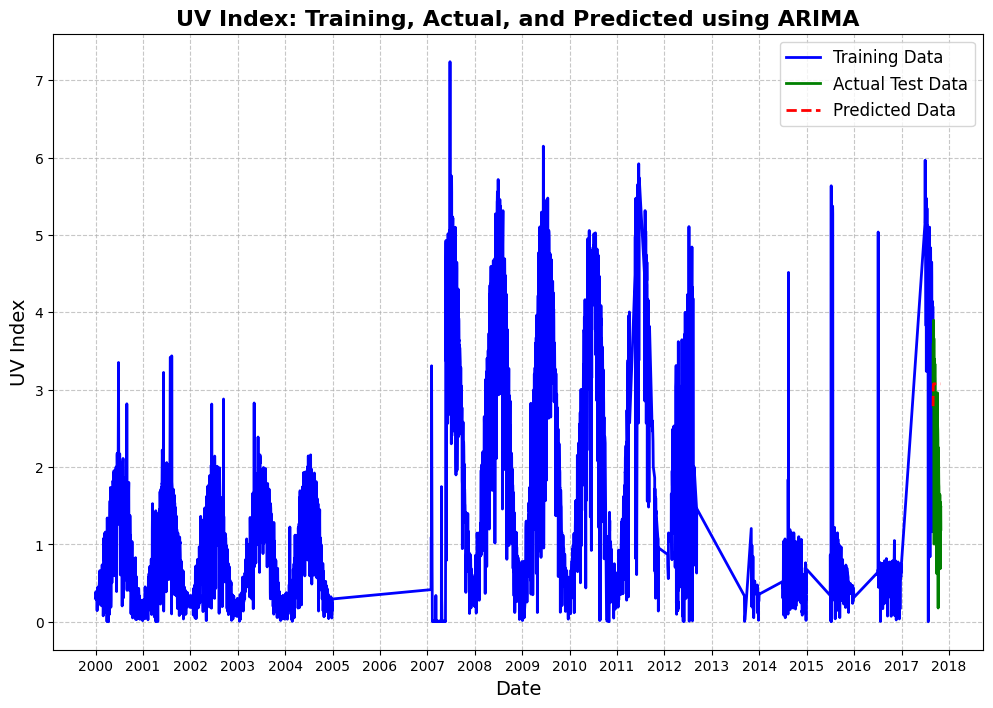

In [ ]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train.index, train.iloc[:, 0], label='Training Data', color='blue', linewidth=2)
plt.plot(test.index, test.iloc[:, 0], label='Actual Test Data', color='green', linewidth=2)
plt.plot(test.index, predicted_values, label='Predicted Data', color='red', linestyle='--', linewidth=2)

plt.title("UV Index: Training, Actual, and Predicted using ARIMA", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("UV Index", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Show only the years on the x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()


# Evaluate the Model

In [ ]:
test_single = test.iloc[:, 0]

mae = mean_absolute_error(test_single, predicted_values)
mse = mean_squared_error(test_single, predicted_values)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 1.01
Mean Squared Error (MSE): 1.54
Root Mean Squared Error (RMSE): 1.24


# **SARIMA Model Training**
**SARIMA=ARIMA Model+Seasonal AR Terms+Seasonal MA Terms+Seasonal Differencing**

Extends ARIMA by adding seasonal components: Seasonal AR and MA terms capture patterns that repeat over a fixed period (e.g., monthly, yearly).

Seasonal differencing removes repeating seasonal trends.

In [ ]:
sarima_model = SARIMAX(
    train['uv_index_daily_max'],
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 12)
)

sarima_result = sarima_model.fit()
print(sarima_result.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Plot Forecast

In [ ]:
# Forecasting
start = len(train)
end = start + len(test) - 1
sarima_forecast = sarima_result.predict(start=start, end=end, typ='levels')

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual Test Data', color='orange')
plt.plot(test.index, sarima_forecast, label='SARIMA Prediction', color='green', linestyle='--')

plt.legend()
plt.title("SARIMA Model - UV Index Forecast")
plt.xlabel("Date")
plt.ylabel("UV Index")
plt.grid(True)

# Ensure only the years appear on the x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Evaluate the model

In [ ]:
mae_sarima = mean_absolute_error(test, sarima_forecast)
mse_sarima = mean_squared_error(test, sarima_forecast)
rmse_sarima = np.sqrt(mse_sarima)

print(f"SARIMA Mean Absolute Error (MAE): {mae_sarima:.2f}")
print(f"SARIMA Mean Squared Error (MSE): {mse_sarima:.2f}")
print(f"SARIMA Root Mean Squared Error (RMSE): {rmse_sarima:.2f}")
